In [3]:
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
import time
from tqdm import tqdm
import networkx as nx

from graph_generation import GenerateGraph, perturb_nx_graph
from models import GCN
from train import Trainer, Dataset
from embedding import Embedding, NodeEmbedding
from experiments import (train_take_embedding, plot_dim1, plot_dimN, plot_correlation_error, get_metrics, 
                         init_GCN, init_model_dataset, train_take_embedding_alreadyinit)
from config_valid import Config, TrainingMode
from plot_model import plot_model
from utils import plot_wo_outliers, plot_grafo2

import torch
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats

import yaml

#from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
#event_acc = EventAccumulator(path="./runs/lr-0.01_epochs45_bs150_neurons-1-8-2_15Sep_16-15-16")
#event_acc.Reload()
# Show all tags in the log file
#print(event_acc.Tags())
#w_times, step_nums, vals = zip(*event_acc.Scalars('Test Loss'))

# Overview del progetto

### Grafi regolari

In [60]:
config_file = "configurations/classification_nodeemb.yml"

In [2]:
config_c_reg = Config(config_file)
gg_reg = GenerateGraph(config_c_reg)
dataset_reg = gg_reg.initialize_dataset()

Generating dataset...
Mean connectivity for each node: 4.0 p=4
Mean connectivity for each node: 7.0 p=7
Dataset generated


In [3]:
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c_reg, dataset_reg, verbose=False)

CrossEntropyLoss()
Loading Dataset...


  0%|                                                                                | 0/600 [00:00<?, ?it/s]/home/daniele/Documenti/Progetti/Networks/Embednet/train.py:281: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  pyg_graph.y = torch.tensor([type_graph], dtype=tipo)
100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:06<00:00, 93.01it/s]


Tempo impiegato: 6.487752199172974
tensor([[1., 0.]], device='cuda:0') 420
tensor([[0., 1.]], device='cuda:0') 180
Run training for 4500 epochs
Before training Test loss: 0.007743841078546312
Epoch: 4499	Test loss: 0.0077036758263905845 		 FINE TRAINING


### grafi regolari con feature random

In [57]:
# ricarico lo stesso config ma ho cambiato la property  random_node_feat: True
config_c_reg = Config(config_file)
gg_reg = GenerateGraph(config_c_reg)
dataset_reg = gg_reg.initialize_dataset()

Generating dataset...
Mean connectivity for each node: 4.0 p=4
Mean connectivity for each node: 7.0 p=7
Dataset generated


In [58]:
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c_reg, dataset_reg, verbose=False)

Loading Dataset...


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:07<00:00, 80.22it/s]


Tempo impiegato: 7.51546573638916
Run training for 450 epochs
Before training Test loss: 0.007775555385483635
Epoch: 449	Test loss: 0.0015366097291310628 		 FINE TRAINING


##### aumento la p della seconda classe

In [53]:
# ricarico lo stesso config ma ho cambiato la property  random_node_feat: True
config_c_reg = Config(config_file)
gg_reg = GenerateGraph(config_c_reg)
dataset_reg = gg_reg.initialize_dataset()

Generating dataset...
Mean connectivity for each node: 4.0 p=4
Mean connectivity for each node: 50.0 p=50
Dataset generated


In [54]:
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c_reg, dataset_reg, verbose=False)

Loading Dataset...


100%|██████████████████████████████████████████████████████████████████████| 600/600 [00:24<00:00, 24.91it/s]


Tempo impiegato: 24.157389163970947
Run training for 450 epochs
Before training Test loss: 0.008260457052124871
Epoch: 449	Test loss: 2.0919011957529518e-05 		 FINE TRAINING


In [ ]:
### verifico che le feature dei nodi sia random
trainer.dataset.dataset_pyg[0].x

### Grafi regolari perturbati, feature costante = 1.0

In [4]:
config_file = "configurations/classification_nodeemb.yml"
config_c_reg = Config(config_file)  # yml file aggiornato con random feat = False

In [21]:
gg_reg = GenerateGraph(config_c_reg)
dataset_reg = gg_reg.initialize_dataset()

Generating dataset...
Mean connectivity for each node: 4.0 p=4
Mean connectivity for each node: 35.0 p=35
Dataset generated


In [22]:
gg_reg.perturb_dataset(0.25, verbose=False) # cambia il dataset_list interno alla classe di dataset

In [23]:
1+1

2

In [24]:
ntipo = config_c_reg.conf['graph_dataset']['Num_grafi_per_tipo']
ntipo

300

In [25]:
print(round(np.array([nx.to_numpy_matrix(t).sum(axis=1).mean() for t in dataset_reg.dataset_list[:ntipo]]).mean(), 3))

10.614


In [26]:
print(round(np.array([nx.to_numpy_matrix(t).sum(axis=1).mean() for t in dataset_reg.dataset_list[ntipo:]]).mean(), 3))

40.206


In [27]:
model, trainer = init_model_dataset(config_c_reg, dataset_reg, verbose=False)

Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████| 600/600 [00:27<00:00, 21.47it/s]


Tempo impiegato: 28.029993057250977


In [28]:
#graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c_reg, dataset_reg, verbose=False)
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding_alreadyinit(trainer) #model, config_c_reg)

Before training Test loss: 0.007600307464599609
Run training for 3000 epochs
Epoch: 2999	Test loss: 0.00780216654141744 		 FINE TRAINING


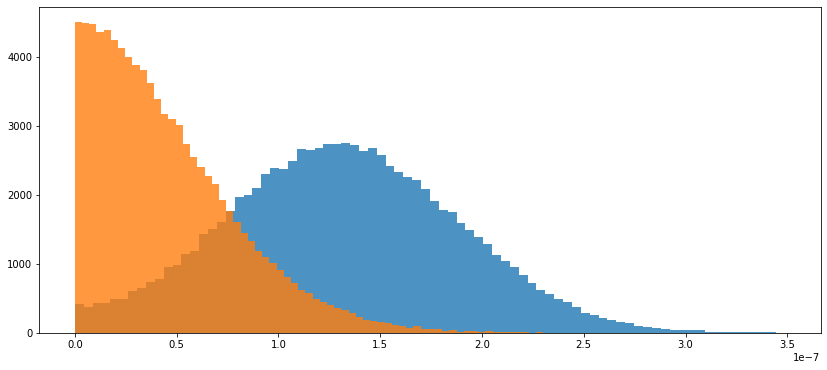

In [6]:
graph_embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c_reg)
node_embeddings = NodeEmbedding(node_embeddings_array, trainer.dataset, test_loss_list, config_c_reg)
num_emb_neurons = model.convs[-1].out_channels
get_metrics(graph_embeddings, num_emb_neurons)

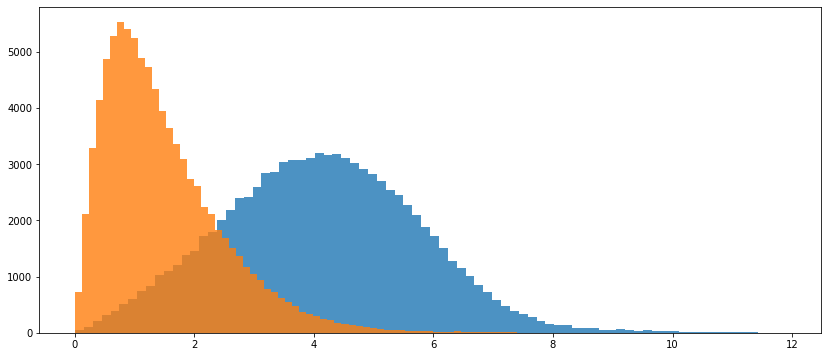

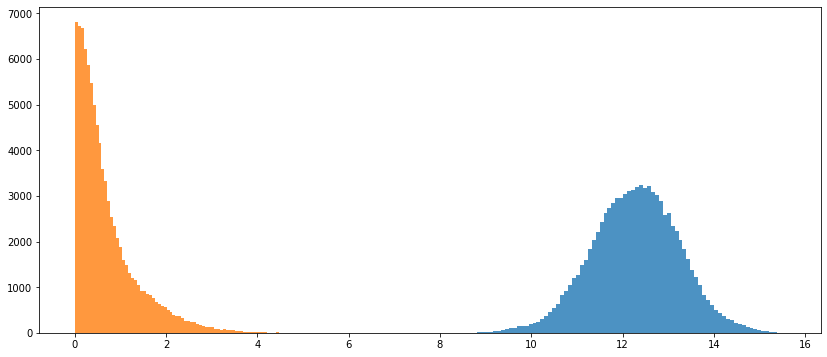

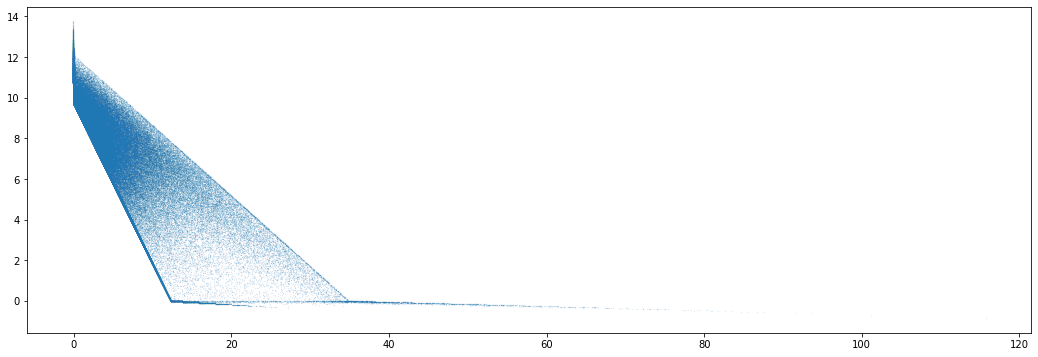

In [61]:
plt.figure(figsize=(18, 6))
plt.scatter(node_embeddings.embeddings_array[:,0], node_embeddings.embeddings_array[:,1], s=0.01, marker='.')

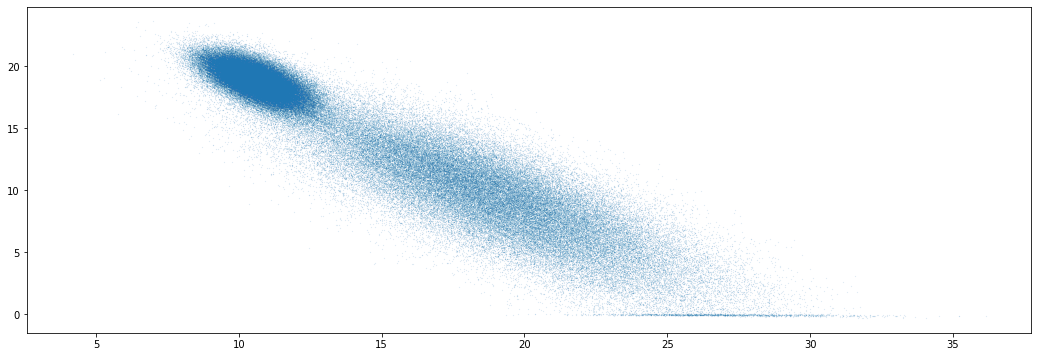

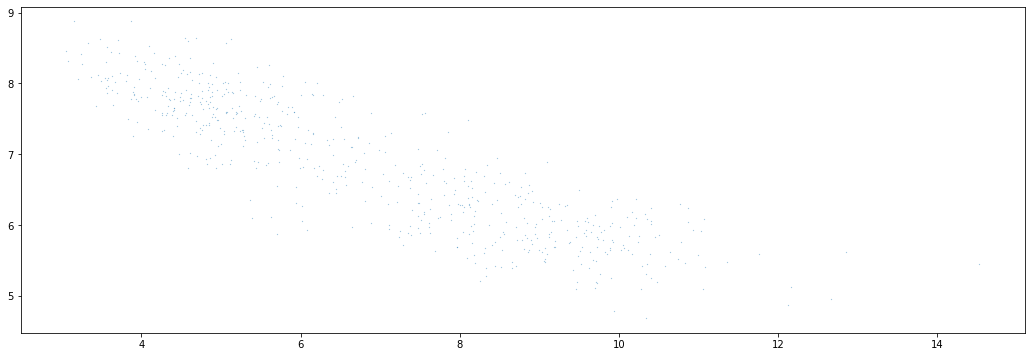

In [62]:
plt.figure(figsize=(18, 6))
plt.scatter(graph_embeddings.embeddings_array[:,0], graph_embeddings.embeddings_array[:,1], s=0.1, marker='.')

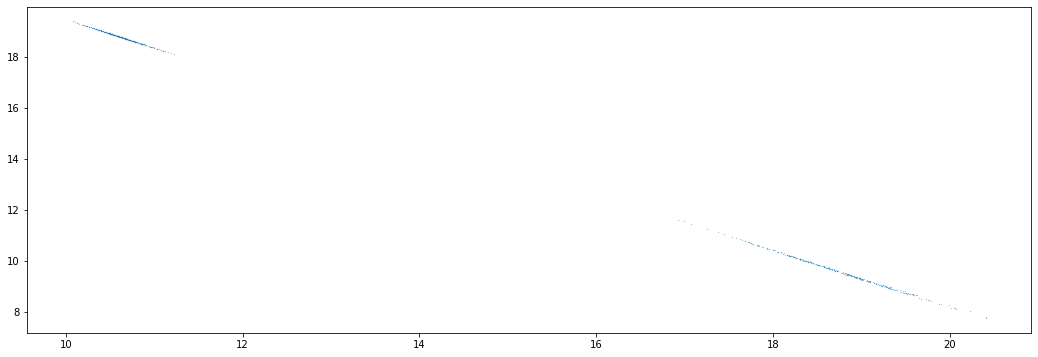

##### Plot delle metriche e degli embedding in funzione dei neuroni e dei layer

### Erdos-Renyi

In [14]:
config_file = "configurations/classification2.yml"
config_c_er = Config(config_file)
gg_er = GenerateGraph(config_c_er)
dataset_er = gg_er.initialize_dataset()

Generating dataset...
Mean connectivity for each node: 14.922 p=0.05
Mean connectivity for each node: 89.763 p=0.3
Dataset generated


In [65]:
#nx.to_numpy_array(dataset_er.dataset_list[0]).sum(axis=1)

In [15]:
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c_er, dataset_er)

Initialize model
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:45<00:00, 13.06it/s]


Tempo impiegato: 46.02156662940979
Before training Test loss: 0.007708856794569227
Run training for 2500 epochs
Epoch: 2499	Test loss: 1.8647338341300685e-05 		 FINE TRAINING


In [16]:
graph_embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c_er)
node_embeddings = NodeEmbedding(node_embeddings_array, trainer.dataset, test_loss_list, config_c_er)

In [51]:
node_embeddings.embeddings_array.shape, graph_embeddings.embeddings_array.shape

((180000, 2), (600, 2))

In [52]:
node_embeddings.get_emb_pergraph_cost()

In [89]:
def node_emb_perclass(classe=[1., 0.]):
    node_emb_class = []
    for i,n in enumerate(node_embeddings.node_emb_pergraph):
        if all(trainer.dataset.labels[i] == classe):
            node_emb_class.extend(n)
    return np.array(node_emb_class)

node_emb_class1 = node_emb_perclass([1., 0.])
node_emb_class2 = node_emb_perclass([0., 1.])


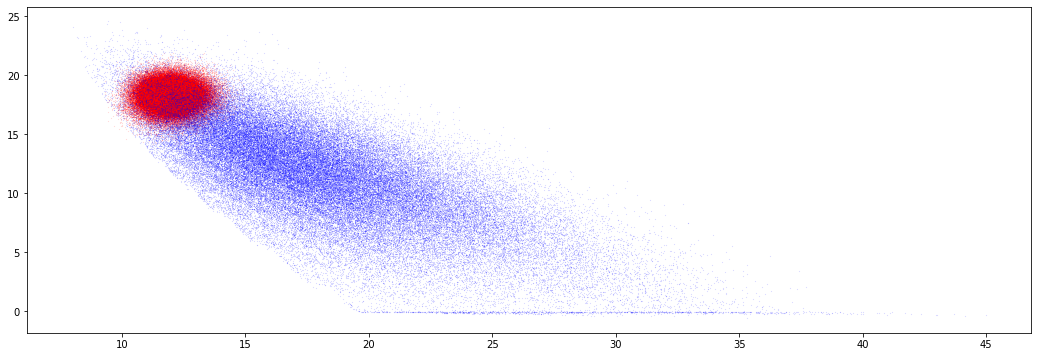

In [94]:
plt.figure(figsize=(18, 6))
plt.scatter(node_emb_class2[:,0], node_emb_class2[:,1], s=0.01, marker='.', color='red');
plt.scatter(node_emb_class1[:,0], node_emb_class1[:,1], s=0.01, marker='.', color='blue');
plt.show()

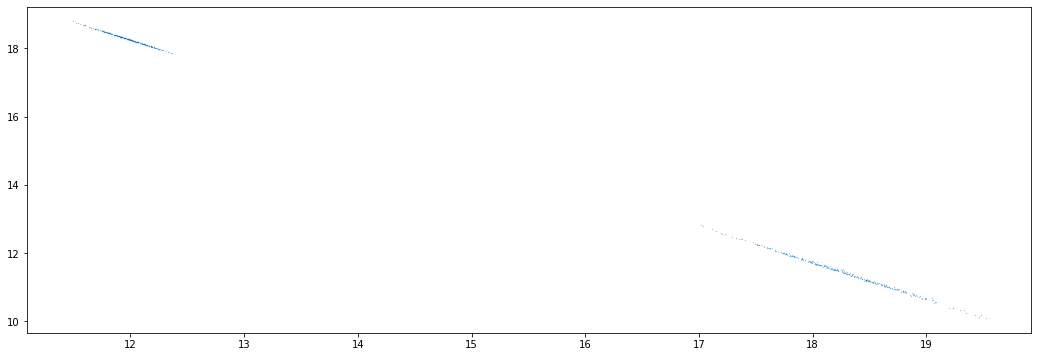

In [95]:
plt.figure(figsize=(18, 6))
plt.scatter(graph_embeddings.embeddings_array[:,0], graph_embeddings.embeddings_array[:,1], s=0.1, marker='.')

##### Plot delle metriche e degli embedding in funzione dei neuroni e dei layer

###### caso Classificazione:  difference of means of distances clusters

###### caso Regressione:  correlazione e plot con le classi se non continuous

# Configuration Model

### Con mean pool aggregator

In [2]:
config_file = "configurations/classification_cm.yml"
config_c_cm = Config(config_file)

In [3]:
gg_cm = GenerateGraph(config_c_cm)
dataset_cm = gg_cm.initialize_dataset()

Generating dataset...
Nodi rimanenti in media: 998.8033333333333


/home/daniele/Documenti/Progetti/Networks/Embednet/graph_generation.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grafi_actual_degrees = np.array(grafi_actual_degrees)


Nodi rimanenti in media: 1782.34
Dataset generated


Draw edges
Draw nodes
Plot
Show


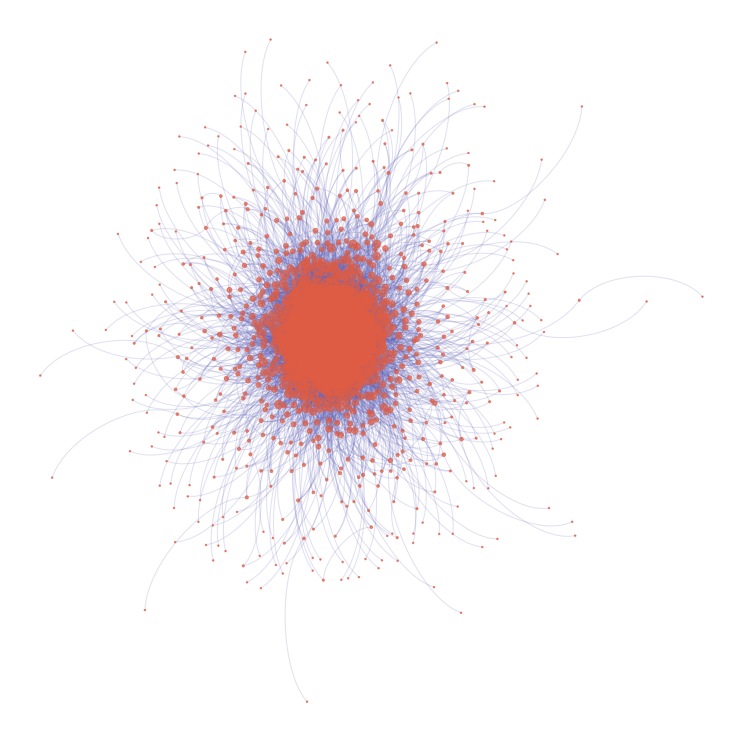

In [15]:
G1 = dataset_cm.dataset_list[1]
plot_grafo2(G1, iterations=1000) # sizes=sizes, edges_weights=edges_weights,

998


[]

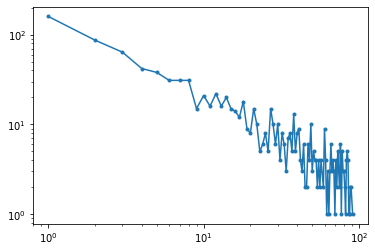

In [17]:
G1 = dataset_cm.dataset_list[1]
print(len(G1.nodes()))
actual_degrees = [d for v, d in G1.degree()]
plt.loglog(*np.unique(actual_degrees, return_counts=True), marker='.');
plt.loglog()

Draw edges
Draw nodes
Plot
Show


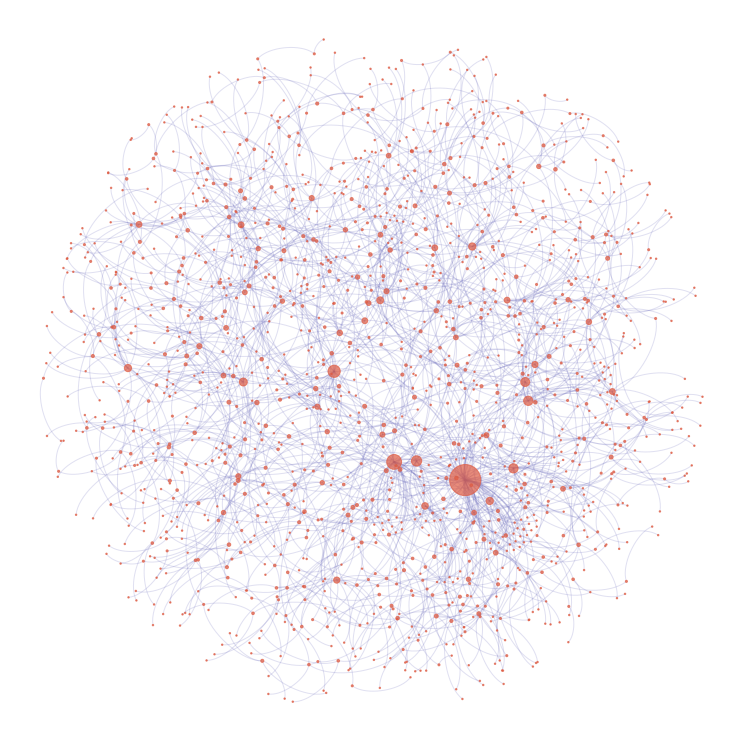

In [8]:
G2 = dataset_cm.dataset_list[550]
plot_grafo2(G2, iterations=1000)

1817


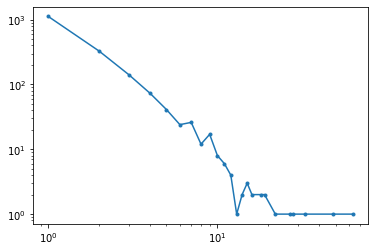

In [18]:
G2 = dataset_cm.dataset_list[520]
print(len(G2.nodes()))
actual_degrees = [d for v, d in G2.degree()]
plt.loglog(*np.unique(actual_degrees, return_counts=True), marker='.');

In [4]:
model, trainer = init_model_dataset(config_c_cm, dataset_cm, verbose=False)

Initialize model
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:44<00:00, 13.63it/s]


Tempo impiegato: 44.08300566673279


In [5]:
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding_alreadyinit(trainer) #, config_c_cm)

Before training Test loss: 0.008245562844806247
Run training for 1000 epochs
Epoch: 999	Test loss: 2.5655479273862307e-05 		 FINE TRAINING


In [45]:
graph_embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c_cm)
node_embeddings = NodeEmbedding(node_embeddings_array, trainer.dataset, test_loss_list, config_c_cm)

In [43]:
node_embeddings.embeddings_array.shape, graph_embeddings.embeddings_array.shape

((834343, 1), (600, 1))

### Correlazione tra node embedding e sequenza di grado

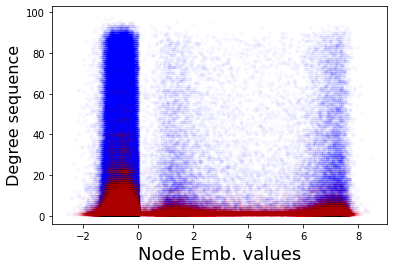

In [36]:
for j in range(0,tot//2):
    emb_i = node_embeddings.node_emb_pergraph[j]
    class_i = np.array(node_embeddings.original_class[j])
    plt.scatter(emb_i, class_i, marker='.', color='blue', alpha=0.02)
for j in range(tot//2,tot):
    emb_i = node_embeddings.node_emb_pergraph[j]
    class_i = np.array(node_embeddings.original_class[j])
    plt.scatter(emb_i, class_i, marker='.', color='red', alpha=0.01)
plt.xlabel('Node Emb. values', fontsize=18);
plt.ylabel('Degree sequence', fontsize=16);
plt.show()

### Sequenza di grado

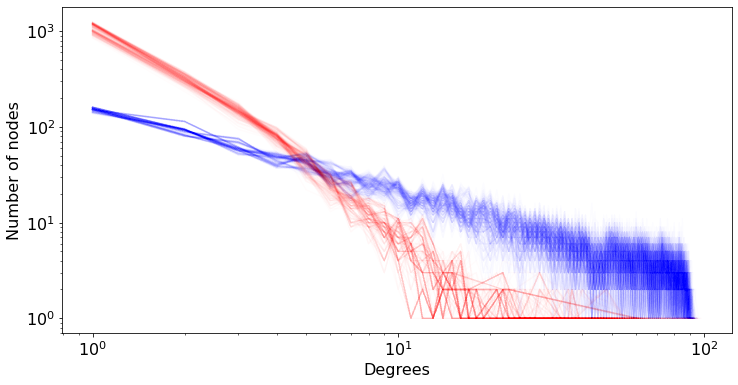

In [37]:
plt.figure(figsize=(12, 6))
tot = len(trainer.dataset.dataset_pyg)
for j in range(0,tot//2):
    plt.loglog(*np.unique(node_embeddings.original_class[j], return_counts=True), c='blue', alpha=0.01)
for j in range(tot//2,tot):
    plt.loglog(*np.unique(node_embeddings.original_class[j], return_counts=True), c='red', alpha=0.01) 
    plt.xlabel('Degrees', fontsize=16);
plt.ylabel('Number of nodes', fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

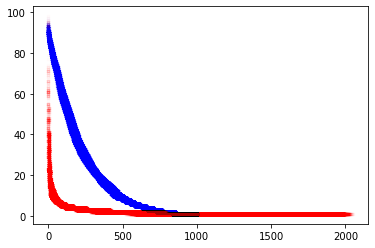

In [14]:
for j in range(0,tot//2):
    actual_degrees_sorted = sorted(node_embeddings.original_class[j], reverse=True)
    plt.plot(actual_degrees_sorted, '.', c='blue', alpha=0.01)
for j in range(tot//2,tot):    
    actual_degrees_sorted = sorted(node_embeddings.original_class[j], reverse=True)
    plt.plot(actual_degrees_sorted, '.', c='red', alpha=0.01)

### Embedding di nodo 

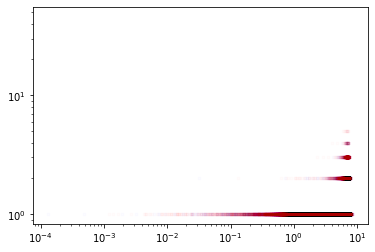

In [16]:
for j in range(0,tot//2):
    plt.loglog(*np.unique(node_embeddings.node_emb_pergraph[j].flatten(), return_counts=True), '.', c='blue', alpha=0.01)
for j in range(tot//2,tot):
    plt.loglog(*np.unique(node_embeddings.node_emb_pergraph[j].flatten(), return_counts=True), '.', c='red', alpha=0.01) 

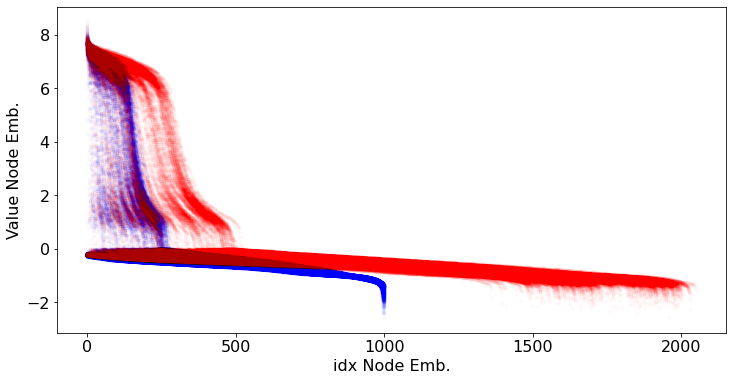

In [38]:
plt.figure(figsize=(12, 6))
for j in range(0,tot//2):
    nodeemb_sorted = sorted(node_embeddings.node_emb_pergraph[j], reverse=True)
    plt.plot(nodeemb_sorted, '.', c='blue', alpha=0.02)
for j in range(tot//2,tot):
    nodeemb_sorted = sorted(node_embeddings.node_emb_pergraph[j], reverse=True)
    plt.plot(nodeemb_sorted, '.', c='red', alpha=0.01)
plt.xlabel('idx Node Emb.', fontsize=16);
plt.ylabel('Value Node Emb.', fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

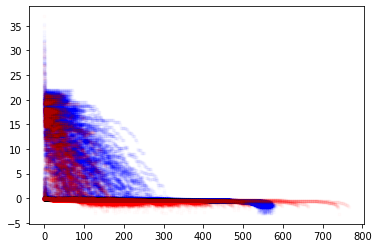

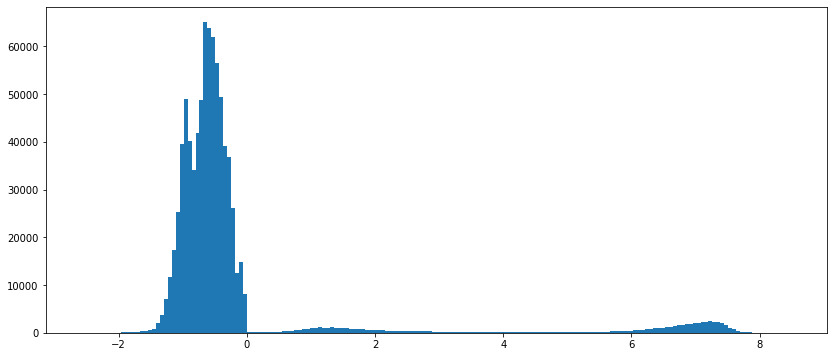

In [28]:
plt.figure(figsize=(14, 6))
plt.hist(node_embeddings.embeddings_array, bins = 180); #, s=0.01, marker='.')

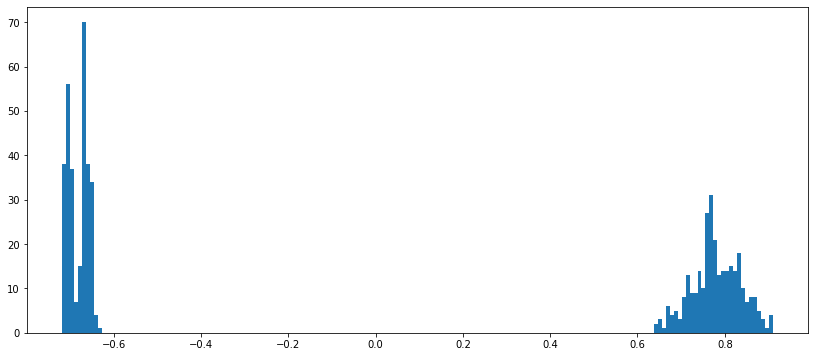

In [29]:
plt.figure(figsize=(14, 6))
#plt.scatter(graph_embeddings.embeddings_array[:,0], graph_embeddings.embeddings_array[:,1], s=0.1, marker='.')
plt.hist(graph_embeddings.embeddings_array, bins = 180);

### graph embedding VS degree max

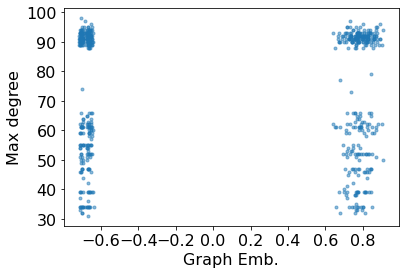

In [59]:
plt.scatter(graph_embeddings.embeddings_array, graph_embeddings.max_degree, marker='.', alpha=0.5)
plt.xlabel('Graph Emb.', fontsize=16);
plt.ylabel('Max degree', fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

### Riprovo togliendo il mean pool dal modello - non si può togliere o ridurre la dimensione in modo graduale

In [15]:
config_file = "configurations/classification_cm.yml"
config_c_cm = Config(config_file)

In [4]:
gg_cm = GenerateGraph(config_c_cm)
dataset_cm = gg_cm.initialize_dataset()

Generating dataset...


/home/daniele/Documenti/Progetti/Networks/Embednet/graph_generation.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grafi_actual_degrees = np.array(grafi_actual_degrees)


Dataset generated


In [14]:
model = init_GCN(config_c_cm, verbose=False)

In [5]:
model, trainer = init_model_dataset(config_c_cm, dataset_cm, verbose=False)

Initialize model
Loading Dataset...


100%|█████████████████████████████████████████████████████| 800/800 [00:08<00:00, 94.87it/s]


Tempo impiegato: 8.485995769500732


In [16]:
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding_alreadyinit(trainer, model, config_c_cm)

Before training Test loss: 0.0031291532019774118
Run training for 1000 epochs
Epoch: 999	Test loss: 0.0031291532019774118 		 FINE TRAINING


In [12]:
graph_embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c_cm)
node_embeddings = NodeEmbedding(node_embeddings_array, trainer.dataset, test_loss_list, config_c_cm)

In [13]:
node_embeddings.get_average_corr_nodeemb()

[-0.00027048 -0.00026503 -0.00019798 -0.0002164  -0.00021223 -0.0002132
 -0.00035531 -0.00030338 -0.00021223 -0.00030965]
[1, 1, 1, 1, 3, 5, 2, 2, 4, 2]
0.2738142366675572


0.0007438978885009344

In [ ]:
#### se il penultimo layer lo metto uguale a 1 (dimensione finale del node embedding) non riesce a imparare, (perché deve riproiettare verso 2?)

# FARE training a 0 epoche, perché così mi collego il prima possibile al tema delle ESN